In [1]:
## import libraries
import h5py
import numpy as np
from PIL import Image
import glob
import time
import matplotlib.pyplot as plt
import logging
from cil.utilities.display import show2D
from cil.recon import FDK
import os
import imageio
from cil.framework import AcquisitionGeometry, ImageGeometry
from cil.plugins.astra import FBP, ProjectionOperator
from cil.optimisation.algorithms import PDHG, FISTA, ISTA, GD, SPDHG, LADMM, SIRT

from cil.optimisation.functions import L2NormSquared, TotalVariation, BlockFunction, IndicatorBox, ZeroFunction, OperatorCompositionFunction, SmoothMixedL21Norm, LeastSquares
from cil.optimisation.operators import BlockOperator, GradientOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.processors import TransmissionAbsorptionConverter, Slicer

from cil.optimisation.utilities import  Sensitivity
from cil.utilities import dataexample


FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



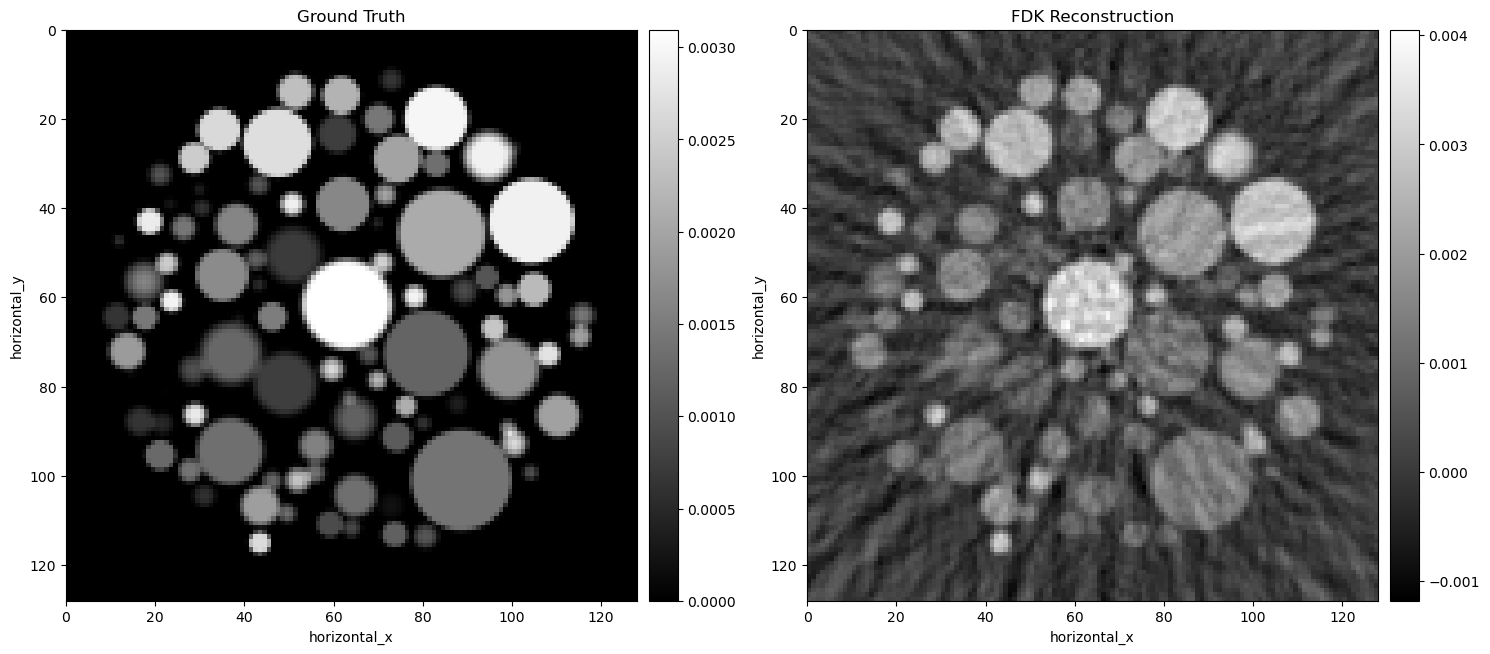

In [2]:

#%% Load data
ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()
twoD = True
if twoD:
    data = data.get_slice(vertical='centre')
    ground_truth = ground_truth.get_slice(vertical='centre')

absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry
ag=data.geometry

#%%
recon = FDK(absorption, image_geometry=ig).run()
#%%
show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2)

# %%


In [3]:
initial = recon   
A = ProjectionOperator(ig, ag, device="gpu")

In [4]:
sirt = SIRT(ig.allocate(0), A, data,   update_objective_interval=1)
sirt.run(100, verbose=2)

  0%|          | 0/100 [00:00<?, ?it/s]

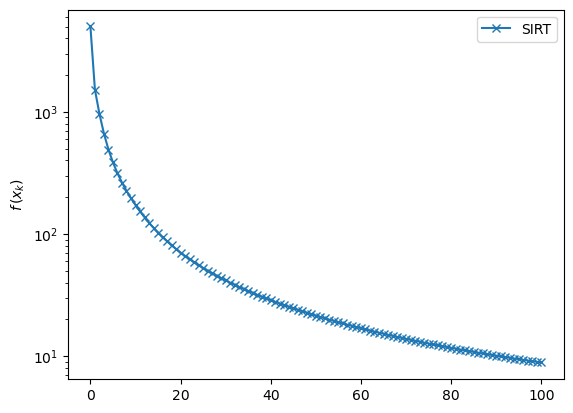

In [5]:
plt.figure()
plt.semilogy(sirt.objective, label="SIRT", marker="x")

plt.legend()
plt.ylabel(r"$f\,(x_{k})$")
plt.show()

In [6]:
M = 1./A.direct(A.domain_geometry().allocate(value=1.0)) 
f = LeastSquares(A=A, b=data, c=0.5, weight=M)
step_size = 1.
preconditioner = Sensitivity(A)

def update_objective(self):
    # SIRT computes |Ax_{k} - b|
    # GDwith weighted LeastSquares computes the objective included the weight, so we remove the weight
    self.loss.append(0.5*(self.objective_function.A.direct(self.x) - self.objective_function.b).squared_norm())
    
GD.update_objective = update_objective

precond_pwls = GD(initial=ig.allocate(0), objective_function=f,   preconditioner = preconditioner,
               max_iteration=100, update_objective_interval=1, step_size = step_size)       

precond_pwls.run(verbose=1 )

/tmp/ipykernel_2738784/429269767.py:16: DeprecationWarning: `run()` missing `iterations`
  precond_pwls.run(verbose=1 )


  0%|          | 0/100 [00:00<?, ?it/s]

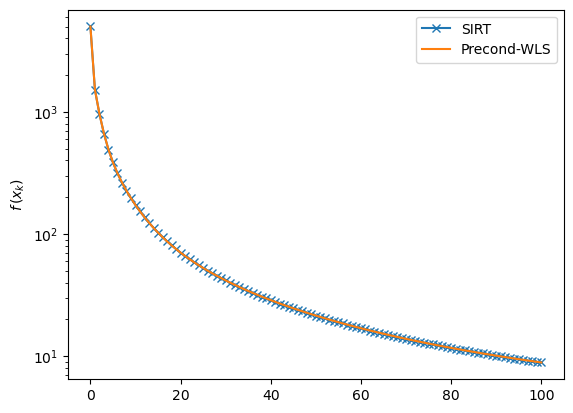

In [7]:
plt.figure()
plt.semilogy(sirt.objective, label="SIRT", marker="x")
plt.semilogy(precond_pwls.objective, label="Precond-WLS")
plt.legend()
plt.ylabel(r"$f\,(x_{k})$")
plt.show()

In [8]:
sirt.objective

[5008.6171875,
 1520.2559814453125,
 963.70361328125,
 664.0663452148438,
 491.8150634765625,
 385.220947265625,
 314.1801452636719,
 263.6083068847656,
 225.668701171875,
 196.08717346191406,
 172.38583374023438,
 153.0264434814453,
 136.9878387451172,
 123.55168914794922,
 112.18974304199219,
 102.5010757446289,
 94.17488098144531,
 86.96673583984375,
 80.68251037597656,
 75.16683959960938,
 70.29464721679688,
 65.96470642089844,
 62.094635009765625,
 58.61699676513672,
 55.47637176513672,
 52.62689971923828,
 50.030452728271484,
 47.655128479003906,
 45.474117279052734,
 43.46472930908203,
 41.60765838623047,
 39.88642883300781,
 38.286834716796875,
 36.79662322998047,
 35.4051513671875,
 34.1031379699707,
 32.88243103027344,
 31.73586082458496,
 30.657094955444336,
 29.6405086517334,
 28.681087493896484,
 27.774341583251953,
 26.91625213623047,
 26.10320472717285,
 25.331920623779297,
 24.59945297241211,
 23.90311050415039,
 23.240440368652344,
 22.60922622680664,
 22.0074176788330

In [9]:
precond_pwls.objective

[5008.6171875,
 1520.2559814453125,
 963.70361328125,
 664.0663452148438,
 491.8150634765625,
 385.220947265625,
 314.1801452636719,
 263.6083068847656,
 225.668701171875,
 196.08717346191406,
 172.38583374023438,
 153.0264434814453,
 136.9878387451172,
 123.55168914794922,
 112.18974304199219,
 102.5010757446289,
 94.17488098144531,
 86.96674346923828,
 80.68250274658203,
 75.16683197021484,
 70.29464721679688,
 65.96470642089844,
 62.09463119506836,
 58.61699676513672,
 55.47637176513672,
 52.62689971923828,
 50.030452728271484,
 47.655128479003906,
 45.47412109375,
 43.46472930908203,
 41.60765838623047,
 39.88642501831055,
 38.286834716796875,
 36.79662322998047,
 35.4051513671875,
 34.1031379699707,
 32.88243103027344,
 31.735862731933594,
 30.657093048095703,
 29.6405086517334,
 28.681087493896484,
 27.774341583251953,
 26.91625213623047,
 26.10320472717285,
 25.33192253112793,
 24.59945297241211,
 23.90311050415039,
 23.24044418334961,
 22.609224319458008,
 22.007417678833008,
 